<a href="https://colab.research.google.com/github/iesous-kurios/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/GJW_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
%matplotlib inline
from scipy import stats

In [0]:

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & 
        (df['SALE_PRICE'] < 2000000) & (df['SALE_PRICE'] > 100000)] 

In [0]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

(2507, 21) (644, 21)


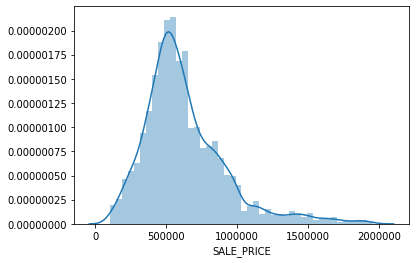

In [0]:
# Do train/test split
# Use data from Jan -March 2019 to train
# Use data from April 2019 to test
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
print(train.shape, test.shape)
sns.distplot(df['SALE_PRICE'])

(3093, 21)


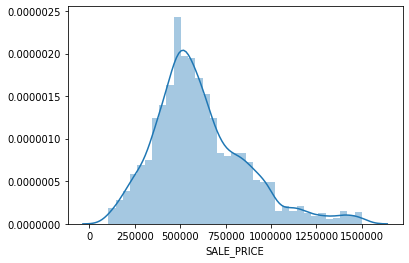

In [0]:
# remove rows where price is greater than or less than 3 sigma
df = df[(np.abs(stats.zscore(df[['SALE_PRICE']])) < 3).all(axis=1)]
print(df.shape)

sns.distplot(df['SALE_PRICE'])

In [0]:
# Remove rows where price, latitude, and longitude are greater than or less than Q3 + 1.5*IQR or Q1 - 1.5*IQR
Q1 = df[['SALE_PRICE']].quantile(0.25)
Q3 = df[['SALE_PRICE']].quantile(0.75)
IQR = Q3 - Q1

temp_df = df[['SALE_PRICE']]
df = df[~((temp_df < (Q1 - 1.5 * IQR)) | (temp_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df.shape)

(2987, 21)


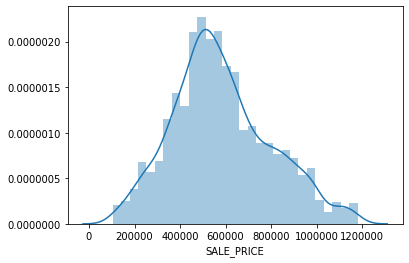

In [0]:
sns.distplot(df['SALE_PRICE'])

In [0]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2507.0,6758.303949,3975.909029,21.0,3837.5,6022.0,9888.5,16350.0
LOT,2507.0,75.778221,157.531138,1.0,21.0,42.0,70.0,2720.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,2507.0,10993.398484,494.291462,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2507.0,0.987635,0.110532,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2507.0,0.016354,0.129966,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2507.0,1.003989,0.171794,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2507.0,1473.744715,599.217635,0.0,1144.0,1368.0,1683.0,7875.0
YEAR_BUILT,2507.0,1944.766653,27.059337,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2507.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [0]:
# TODO
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2507,5,4,1204,NaT,NaT
NEIGHBORHOOD,2507,7,OTHER,2360,NaT,NaT
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaT,NaT
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaT,NaT
ADDRESS,2507,2497,130-52 LEFFERTS BOULEVARD,2,NaT,NaT
APARTMENT_NUMBER,1,1,RP.,1,NaT,NaT
LAND_SQUARE_FEET,2507,887,"4,000",234,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaT,NaT
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [0]:
df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01


In [0]:
# Compare sale price by 
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    739000.000000
2    473104.623967
3    768734.633166
4    649005.172757
5    537305.802115
Name: SALE_PRICE, dtype: float64

In [0]:
for col in train:
  print(col)

BOROUGH
NEIGHBORHOOD
BUILDING_CLASS_CATEGORY
TAX_CLASS_AT_PRESENT
BLOCK
LOT
EASE-MENT
BUILDING_CLASS_AT_PRESENT
ADDRESS
APARTMENT_NUMBER
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE
SALE_PRICE
SALE_DATE


In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2507 entries, 44 to 18147
Data columns (total 21 columns):
BOROUGH                           2507 non-null object
NEIGHBORHOOD                      2507 non-null object
BUILDING_CLASS_CATEGORY           2507 non-null object
TAX_CLASS_AT_PRESENT              2507 non-null object
BLOCK                             2507 non-null int64
LOT                               2507 non-null int64
EASE-MENT                         0 non-null float64
BUILDING_CLASS_AT_PRESENT         2507 non-null object
ADDRESS                           2507 non-null object
APARTMENT_NUMBER                  1 non-null object
ZIP_CODE                          2507 non-null float64
RESIDENTIAL_UNITS                 2507 non-null float64
COMMERCIAL_UNITS                  2507 non-null float64
TOTAL_UNITS                       2507 non-null float64
LAND_SQUARE_FEET                  2507 non-null object
GROSS_SQUARE_FEET                 2507 non-null float64
YEAR_BUILT   

In [0]:
# TODO
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS','APARTMENT_NUMBER','RESIDENTIAL_UNITS','COMMERCIAL_UNITS', 
                    'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_CATEGORY',
                    'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_PRESENT', 'TAX_CLASS_AT_TIME_OF_SALE',
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE', 'EASE-MENT']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
print(X_train.shape)
X_train.head()

(2507, 7)


,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT
44,3,OTHER,5495,801,11230.0,1325.0,1930.0
61,4,OTHER,7918,72,11427.0,2001.0,1940.0
78,2,OTHER,4210,19,10461.0,2043.0,1925.0
108,3,OTHER,5212,69,11226.0,2680.0,1899.0
111,3,OTHER,7930,121,11203.0,1872.0,1940.0


In [0]:
# TODO
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [0]:
# TODO
print(X_train.shape)
X_train.head()

(2507, 17)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BLOCK,LOT,ZIP_CODE,GROSS_SQUARE_FEET,YEAR_BUILT
44,1,0,0,0,0,1,0,0,0,0,0,0,5495,801,11230.0,1325.0,1930.0
61,0,1,0,0,0,1,0,0,0,0,0,0,7918,72,11427.0,2001.0,1940.0
78,0,0,1,0,0,1,0,0,0,0,0,0,4210,19,10461.0,2043.0,1925.0
108,1,0,0,0,0,1,0,0,0,0,0,0,5212,69,11226.0,2680.0,1899.0
111,1,0,0,0,0,1,0,0,0,0,0,0,7930,121,11203.0,1872.0,1940.0


In [0]:
# TODO: Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)
from sklearn.feature_selection import f_regression, SelectKBest

# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(2507, 15)

In [0]:
# TODO: Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BLOCK
LOT
ZIP_CODE
GROSS_SQUARE_FEET
YEAR_BUILT

Features Not Selected:
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT


In [0]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $183,641 

2 features:
Test MAE: $184,337 

3 features:
Test MAE: $183,041 

4 features:
Test MAE: $177,282 

5 features:
Test MAE: $177,884 

6 features:
Test MAE: $177,482 

7 features:
Test MAE: $172,593 

8 features:
Test MAE: $171,870 

9 features:
Test MAE: $163,860 

10 features:
Test MAE: $159,590 

11 features:
Test MAE: $159,628 

12 features:
Test MAE: $160,343 

13 features:
Test MAE: $160,332 

14 features:
Test MAE: $160,334 

15 features:
Test MAE: $160,141 

16 features:
Test MAE: $160,141 

17 features:
Test MAE: $160,141 



In [0]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $183,641 

2 features:
Test MAE: $184,337 

3 features:
Test MAE: $183,041 

4 features:
Test MAE: $177,282 

5 features:
Test MAE: $177,884 

6 features:
Test MAE: $177,482 

7 features:
Test MAE: $172,593 

8 features:
Test MAE: $171,870 

9 features:
Test MAE: $163,860 

10 features:
Test MAE: $159,590 

11 features:
Test MAE: $159,628 

12 features:
Test MAE: $160,343 

13 features:
Test MAE: $160,332 

14 features:
Test MAE: $160,334 

15 features:
Test MAE: $160,141 

16 features:
Test MAE: $160,141 

17 features:
Test MAE: $160,141 



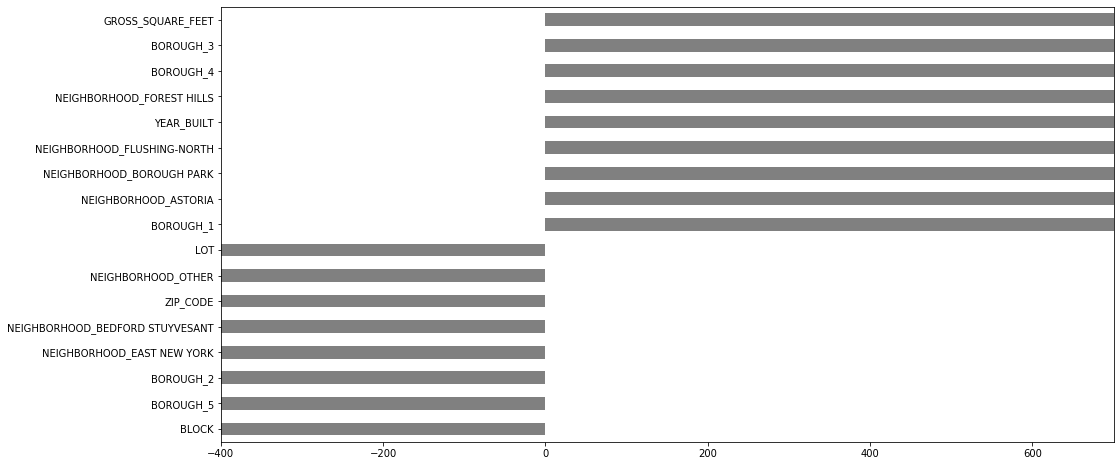

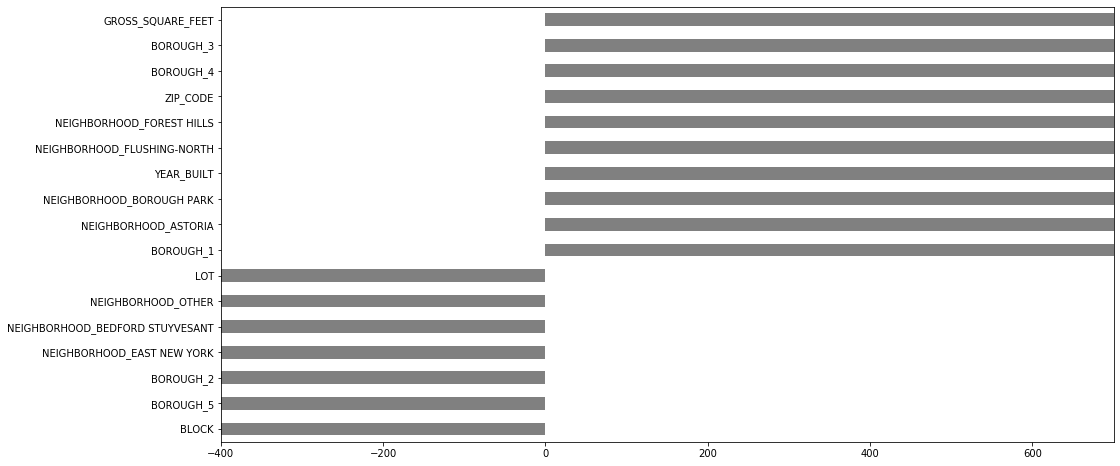

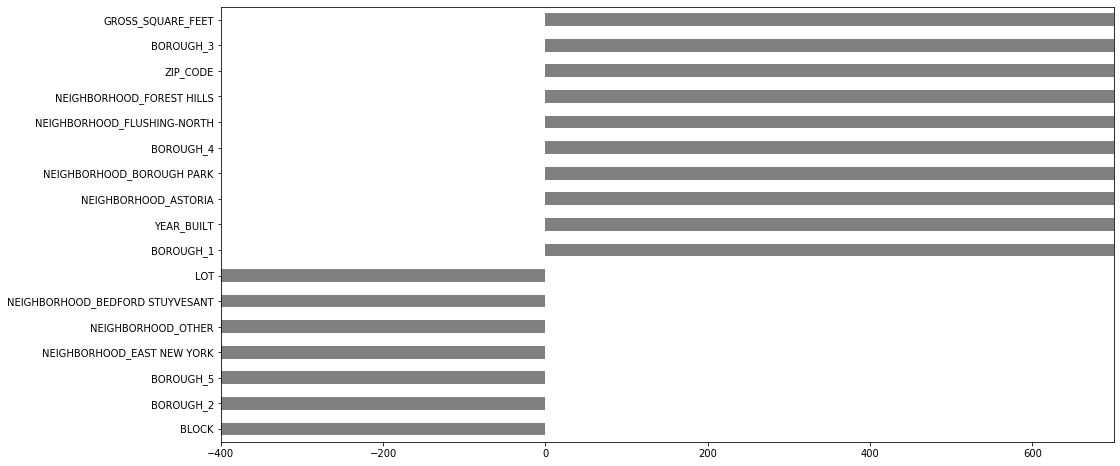

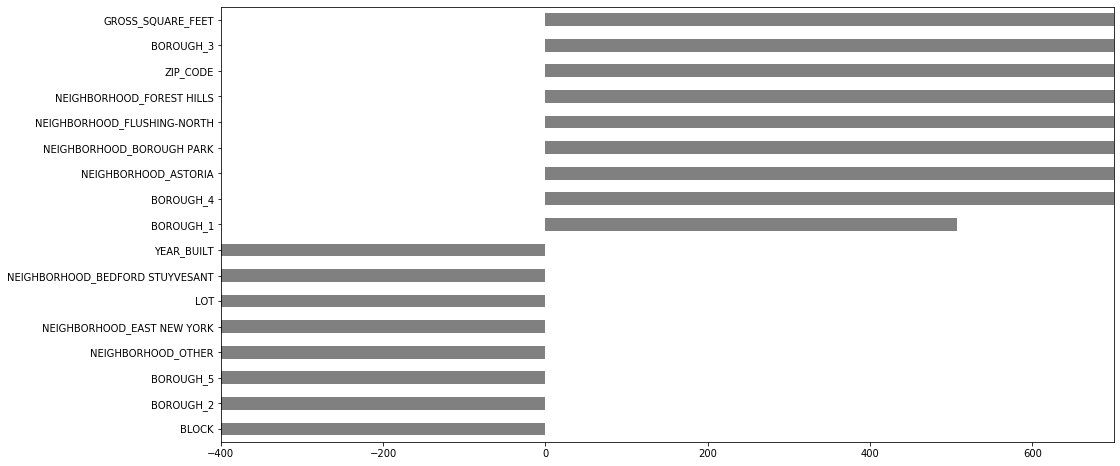

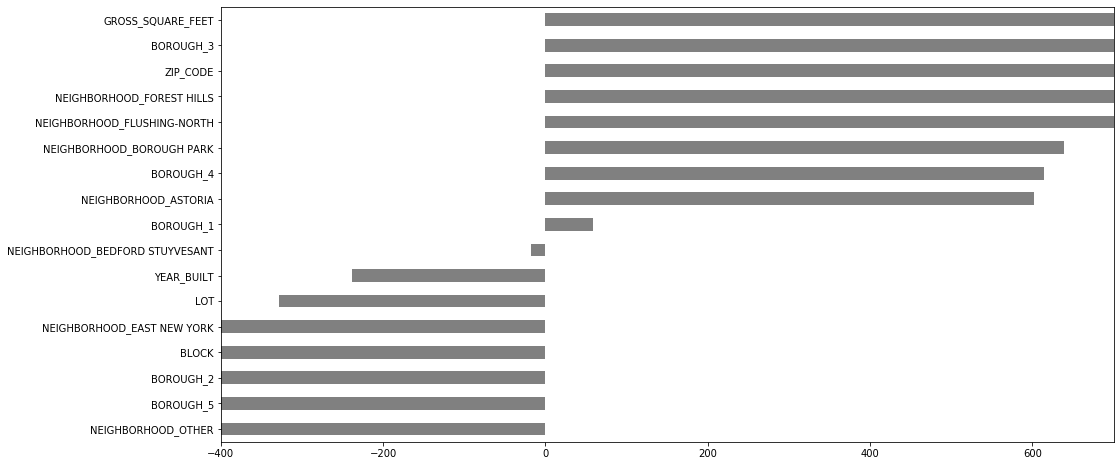

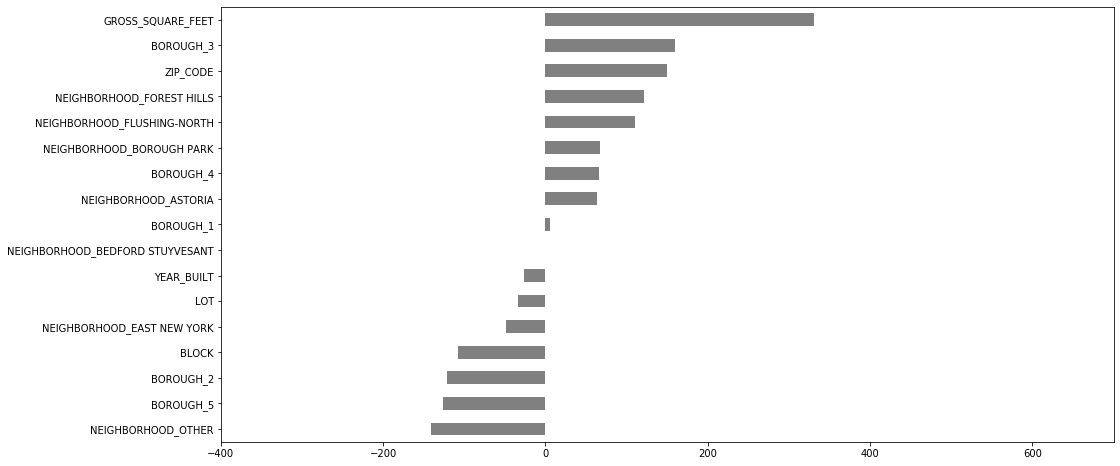

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

In [0]:
from sklearn.metrics import mean_squared_error

alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 32895913425264.113
1 54718227455.95725
2 54730173255.42805
3 54759761473.55328
4 54801441061.084206
5 54851224409.99898
6 54906299497.83349
7 54964676002.7721
8 55024935609.24284
9 55086062028.03347
10 55147324977.08814
11 55208200028.92315
12 55268312450.85344
13 55327397311.05864
14 55385270778.22291
15 55441809238.13577
16 55496933944.74932
17 55550599639.33077
18 55602786047.36679
19 55653491484.12138
20 55702728019.709
21 55750517807.19852
22 55796890284.5558
23 55841880037.51536
24 55885525165.297806
25 55927866030.88421
26 55968944306.70539
27 56008802248.138245
28 56047482143.22712
29 56085025899.0705
30 56121474734.382324
31 56156868954.629196
32 56191247791.406845
33 56224649291.758965
34 56257110246.25948
35 56288666147.09631
36 56319351169.27203
37 56349198169.50779
38 56378238698.58598
39 56406503023.77247
40 56434020158.671936
41 56460817898.43331
42 56486922858.66887
43 56512360516.8037
44 56537155254.8544
45 56561330402.85759
46 56584908282.34882
47 56607910249.43207


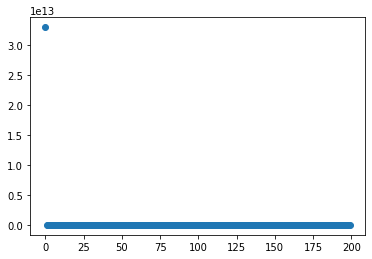

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);